# Node degree distribution of Cora dataset

Some nodes (hubs) have very large numbers of neighbors

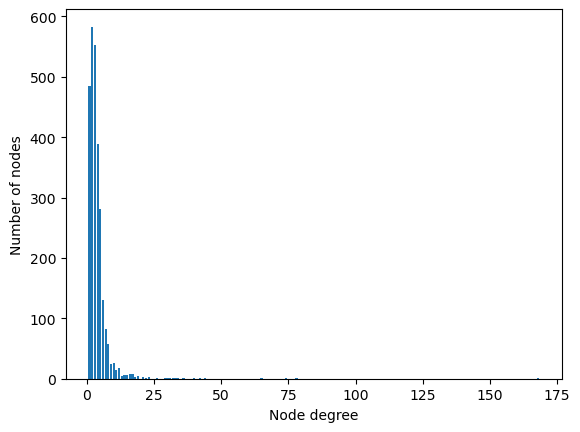

In [25]:
# import dataset
try:
    from torch_geometric.datasets import Planetoid
except:
    !pip install -q torch-geometric
    from torch_geometric.datasets import Planetoid
from sources.revisited_utils import visualize_node_degree

# Download Cora dataset
cora_dataset = Planetoid(root='.', name='Cora')
cora_data = cora_dataset[0]

# visualize the node degree
visualize_node_degree(data=cora_data)

# Node degree distribution of Facebook page-page dataset

Some nodes (hubs) have very large number of neighbors.

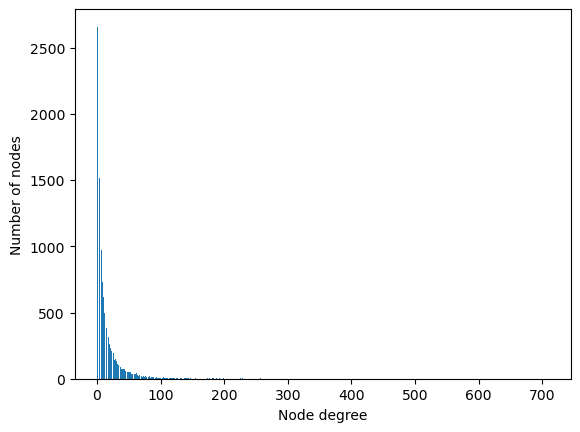

In [26]:
# import torch_geometric datasets
from torch_geometric.datasets import FacebookPagePage
import torch_geometric.transforms as gtransforms

# download facebook page-page dataset
facebook_dataset = FacebookPagePage(
    root='.',
    transform=gtransforms.RandomNodeSplit(
        num_val=2000,
        num_test=2470
    )
)
facebook_data = facebook_dataset[0]

# visualize the node degree
visualize_node_degree(data=facebook_data)

# Node feature normalization

- In the Vanilla GNN model, the node embedding of node A $(h_A)$, is given by:

> $h_A = \sum\limits_{i\in N_A} x_iW^T$

- Where $x_i$ is node feature vector and $W$ is the weight matrix. In the matrix form, the node embedding matrix is given by:

> $H = \tilde{A}^T XW^T$

- Where $\tilde{A} = A + I$, in which $A$ and $I$ are adjacency and identity matrices.
  
***

- As shown in Cora and Facebook datasets, some nodes have large number of neighbors, which will produce very large node embedding. For a meaningful comparision, one needs to normalize node embeddings by their corresponding node degree, e.g., $deg(A)$. Node A embedding becomes:

> $h_A = \frac{1}{deg(A)} \sum\limits_{i\in N_A} x_iW^T$

- The normalization factor can be obtained by inverting the augmented node degree matrix $(\tilde{D} = D + I)$. Here, D is the node degree matrix and I is the identity matrix. Node embedding with normalize features using node degree matrix can be obtained by 2 ways:

> $H = \tilde{D}^{-1} \tilde{A}^T XW^T$

> $H =  \tilde{A}^T \tilde{D}^{-1} XW^T$

- The best option is compromising between row and column normalization:

> $H =  \tilde{D}^{-1/2} \tilde{A}^T \tilde{D}^{-1/2} XW^T$

- Individual normalized node embedding is given by:

> $h_A = \frac{1}{\sqrt{deg(A)}} \sum\limits_{i\in N_A} \frac{1}{\sqrt{deg(i)}} x_iW^T$

- Node feature normalization is introduced in the <font color=green> Graph Convolutional Network (GCN) </font>

# Implement a simple GCN for node classification

In [27]:
import torch
from torch.nn import functional
from torch_geometric.nn import GCNConv

# define GCN class
class GCN(torch.nn.Module):
    
    def __init__(self, dim_in:int, dim_h:int, dim_out:int):
        super().__init__()
        self.gcn1 = GCNConv(in_channels=dim_in, out_channels=dim_h)
        self.gcn2 = GCNConv(in_channels=dim_h, out_channels=dim_out)

    def forward(self, x:torch.Tensor, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return functional.log_softmax(h, dim=1)

**Applying GCN to Cora dataset**

In [28]:
# create a GCN instance for Cora dataset
cora_model = GCN(
    dim_in=cora_dataset.num_features,
    dim_h=16,
    dim_out=cora_dataset.num_classes
)

In [29]:
# setup loss function
loss_fn = torch.nn.CrossEntropyLoss()
# setup optimizer with L2 regularization (weight_decay) of 5e-4
optimizer = torch.optim.Adam(params=cora_model.parameters(), lr=1e-2, weight_decay=5e-4)

In [30]:
# train GCN model with epochs=101
from sources.revisited_engine import train, test

cora_results = train(
    model=cora_model,
    data=cora_data,
    loss_fn=loss_fn,
    optimizer=optimizer,
    adjacency=cora_data.edge_index,
    epochs=101
)

  0%|          | 0/101 [00:00<?, ?it/s]

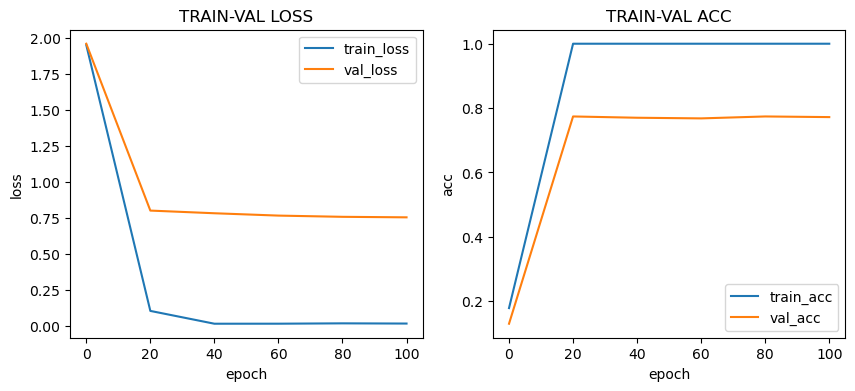

In [31]:
# visualize the training and validating results
from sources.revisited_utils import visualize_results

visualize_results(results=cora_results)

In [32]:
# compute test accuracy
test_acc = test(
    model=cora_model,
    data=cora_data,
    adjacency=cora_data.edge_index
)

print(f"Test accuracy: {test_acc*100:.1f}(%)")

Test accuracy: 81.8(%)


**Applying GCN to Facebook page-page dataset**

In [33]:
# create GCN model for Facebook page-page dataset
facebook_model = GCN(
    dim_in=facebook_dataset.num_features,
    dim_h=16,
    dim_out=facebook_dataset.num_classes
)
facebook_model

GCN(
  (gcn1): GCNConv(128, 16)
  (gcn2): GCNConv(16, 4)
)

In [34]:
# setup loss function
loss_fn = torch.nn.CrossEntropyLoss()
# setup optimizer with L2 regularization (weight_decay) of 5e-4
optimizer = torch.optim.Adam(params=facebook_model.parameters(), lr=1e-2, weight_decay=5e-4)

In [35]:
# train GCN model for Facebook Page-Page dataset
facebook_results = train(
    model=facebook_model,
    data=facebook_data,
    loss_fn=loss_fn,
    optimizer=optimizer,
    adjacency=facebook_data.edge_index,
    epochs=101
)

  0%|          | 0/101 [00:00<?, ?it/s]

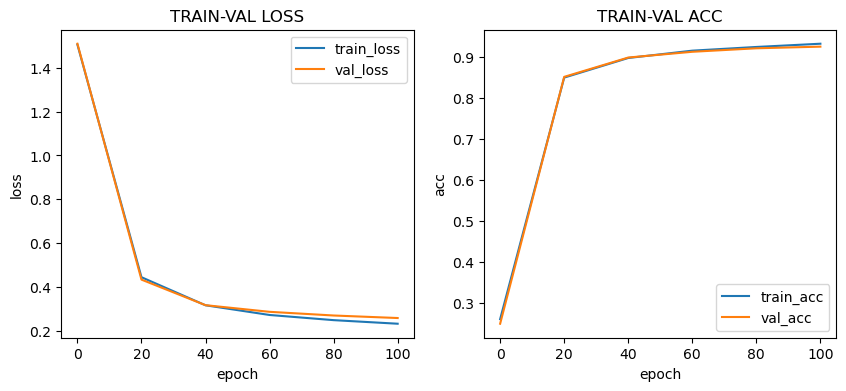

In [36]:
# visualize the facebook page-page results
visualize_results(results=facebook_results)

In [37]:
# computes test accuracy
test_acc = test(
    model=facebook_model,
    data=facebook_data,
    adjacency=facebook_data.edge_index
)

print(f"Test accuracy: {test_acc*100:.1f}(%)")

Test accuracy: 92.3(%)


## Wikipedia network dataset

* WikipediaNetwork dataset contains 3 page-page networks:
    * Chameleons with 2,277 nodes and 31, 421 edges
    * Crocodiles with 11,631 nodes and 170,918 edges
    * Squirrels with 5,201 nodes and 198,493 edges
* Here, nodes are articles and edges are mutual links between articles.
* The goal is to predict the log average monthly traffic. This is a <font color=red> node regression </font> task that output continuous numbers, which is different from <font color=green> node classification </font> task.

In [38]:
# import dataset
from torch_geometric.datasets import WikipediaNetwork
import torch_geometric.transforms as gtransform

# download wikinetwork chameleon dataset
wiki_dataset = WikipediaNetwork(
    root='.',
    name='chameleon',
    transform=gtransform.RandomNodeSplit(
        num_val=200,
        num_test=500
    )
)
wiki_data=wiki_dataset[0]

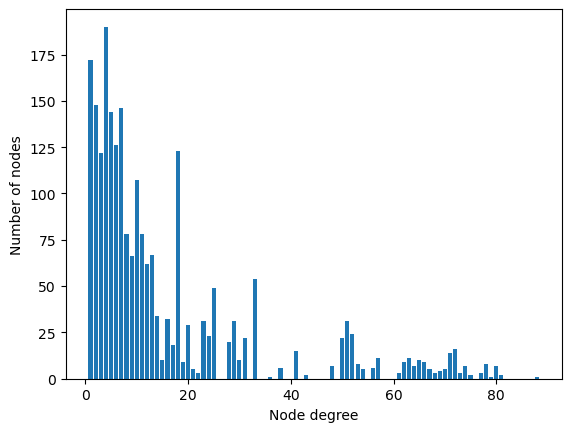

In [39]:
# visualize node degree of the wiki dataset
visualize_node_degree(data=wiki_data)

In [40]:
# download wikipedia traffic
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

url = 'https://snap.stanford.edu/data/wikipedia.zip'
with urlopen(url=url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

In [41]:
# download average web traffic and take log
import pandas as pd
import numpy as np

df = pd.read_csv('wikipedia/chameleon/musae_chameleon_target.csv')
values = np.log10(df['target'])
wiki_data.y = torch.tensor(values)
wiki_data.y

tensor([2.2330, 3.9079, 3.9329,  ..., 1.9956, 4.3598, 2.4409],
       dtype=torch.float64)

/tmp/ipykernel_1278/3293651287.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = sbn.distplot(df['target'], fit=norm)


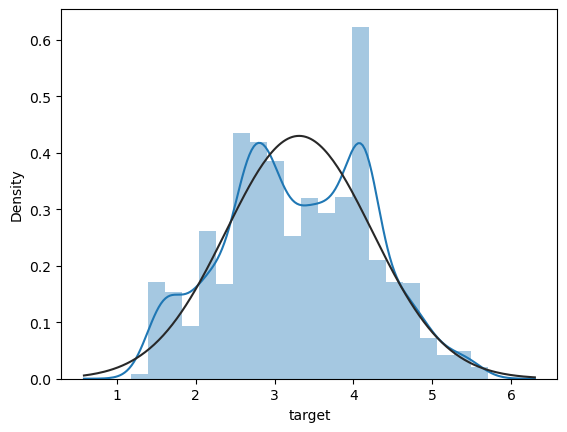

In [42]:
# visualize the average web traffic distribution with seaborn
try:
    import seaborn as sbn
except:
    !pip install seaborn
    import seaborn as sbn
from scipy.stats import norm

df['target'] = values
fig = sbn.distplot(df['target'], fit=norm)

## Implement GCN for node regression

In [43]:
class GCN(torch.nn.Module):
    def __init__(self, dim_in: int, dim_h: int, dim_out: int):
        super().__init__()
        self.gcn1 = GCNConv(in_channels=dim_in, out_channels=dim_h*4)
        self.gcn2 = GCNConv(in_channels=dim_h*4, out_channels=dim_h*2)
        self.gcn3 = GCNConv(in_channels=dim_h*2, out_channels=dim_h)
        self.linear = torch.nn.Linear(in_features=dim_h, out_features=dim_out)

    def forward(self, x:torch.Tensor, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = functional.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        h = torch.relu(h)
        h = functional.dropout(h, p=0.5, training=self.training)
        h = self.gcn3(h, edge_index)
        h = torch.relu(h)
        h = self.linear(h)
        return h

In [44]:
wiki_gcn_model = GCN(
    dim_in=wiki_dataset.num_features,
    dim_h = 128,
    dim_out=1
)
wiki_gcn_model

GCN(
  (gcn1): GCNConv(2325, 512)
  (gcn2): GCNConv(512, 256)
  (gcn3): GCNConv(256, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

In [45]:
# GCN regression train
from sources.revisited_engine import train_regression

results = train_regression(
    model=wiki_gcn_model,
    data=wiki_data,
    epochs=201,
    print_results=True
)


  0%|          | 0/201 [00:00<?, ?it/s]

    0 | 12.055 | 12.251
   20 | 11.403 | 11.670
   40 | 4.329 | 4.848
   60 | 0.850 | 1.084
   80 | 0.575 | 0.744
  100 | 0.470 | 0.694
  120 | 0.435 | 0.651
  140 | 0.437 | 0.787
  160 | 0.355 | 0.715
  180 | 0.354 | 0.651
  200 | 0.329 | 0.666


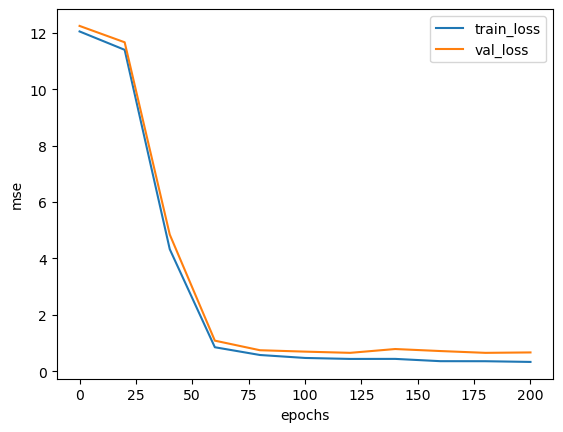

In [46]:
# visualize train and validation MSE loss 
import matplotlib.pyplot as plt
plt.plot(results['epoch'], results['train_loss'], label='train_loss')
plt.plot(results['epoch'], results['val_loss'], label='val_loss')
plt.xlabel("epochs")
plt.ylabel("mse")
plt.legend()

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

out = wiki_gcn_model(wiki_data.x, wiki_data.edge_index)
y_pred = out.squeeze()[wiki_data.test_mask].detach().numpy()
mse = mean_squared_error(wiki_data.y[wiki_data.test_mask], y_pred)
mae = mean_absolute_error(wiki_data.y[wiki_data.test_mask], y_pred)

print('=' * 43)
print(f'MSE = {mse:.4f} | RMSE = {np.sqrt(mse):.4f} | MAE = {mae:.4f}')
print('=' * 43)

MSE = 0.5743 | RMSE = 0.7578 | MAE = 0.5858


[Text(0.5, 0, 'Ground truth'), Text(0, 0.5, 'Predicted values')]

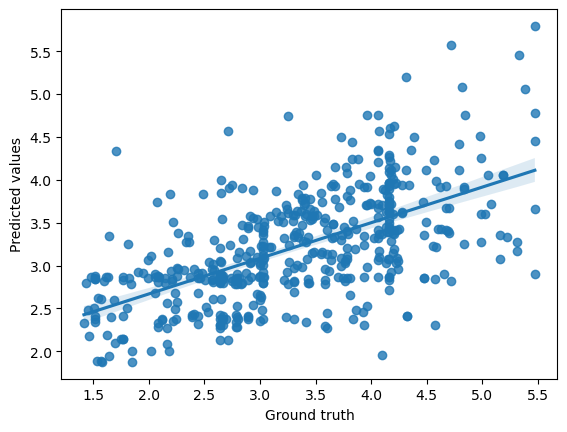

In [48]:
fig = sbn.regplot(x=wiki_data.y[wiki_data.test_mask].numpy(), y=y_pred)
fig.set(xlabel='Ground truth', ylabel='Predicted values')